In [1]:
#this is a cross repository project for web scraping
#at first, the idea was to get as much info on MENA region as possible
#the initial idea was to scrape news from various websites
#somehow i realized, many contents were similar
#reuters, al jazeera, bbc, cnn, they all covered the major news
#it was a waste of time and energy to read the similar content more than once
#that was when i began to think about extracting key information
#and graph structure turned out to be the ideal approach for this scenario
#in order to make this script fully functional, some assumptions need to be made
#the major news should be headlined on every big news website
#if it is important enough, every media should cover the topic
#the title for this topic from different sources should share some common words
#for instance, 'he goes to school on foot' from website alpha
#on website beta, the title is probably 'he walks to school'
#on website gamma, it could be 'he goes to school using his feet'
#therefore, if we build a graph network to connect all the titles together
#the major news must be the nodes with the highest degree
#all we need to do is to use a traversal algorithm to get these nodes

#in terms of scraping news content from different online sources
#plz refer to the following link for more details
# https://github.com/je-suis-tm/web-scraping/blob/master/MENA%20Newsletter.py

#this file is a demonstration of graph theory vs machine learning
#the python script is in the following link
# https://github.com/je-suis-tm/graph-theory/blob/master/Text%20Mining%20project/text_mining.py

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import random as rd
import numpy as np
import os
os.chdir('k:/a')

In [2]:
#the selection of stopword is crucial
#for our particular problem, some location names should be included
#for instance, we could get a title, 'minister in iran get arrested'
#and another title, 'the economy in iran is slowing down'
#they can be connected via common word iran
#yet, they share no similar content at all
stopword=stopwords.words('english')+['algeria',
 'algerian',
 'arabia',
 'arabian',
 'around',
 'b',
 'back',
 'bahrain',
 'beyond',
 'c',
 'e',
 'egyptian',
 'emirates',
 'f',
 'first',
 'g',
 'h',
 'iran',
 'iranian',
 'iranians',
 'iraq',
 'israel',
 'israeli',
 'j',
 'jerusalem',
 'jordan',
 'k',
 'kuwait',
 'l',
 'lebanon',
 'lebanonese',
 'moroccan',
 'morocco',
 'n',
 'oman',
 'p',
 'pakistan',
 'palestinian',
 'palestinians',
 'q',
 'qatar',
 'qatari',
 'r',
 'russia',
 'russian',
 'saudi',
 'syria',
 'syrian',
 'tunisia',
 'tunisian',
 'turkey',
 'turkish',
 'u',
 'us',
 'v',
 'w',
 'within',
 'would',
 'x',
 'yemen',
 'yemeni',
 'z']

In [3]:
#convert text into a list of words
#we can use stemming and lemmatization to improve efficiency
#for instance, we have words walked,walking,walks
#with nltk package, we can revert all of them to walk
def text2list(text,stopword,lower=True,lemma=False,stemma=False):

    text_clean=text if lower==False else text.lower()
    
    #tokenize and remove stop words
    token=[i for i in nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text_clean) if i not in stopword]
    
    #lemmatization
    if lemma:
        text_processed=[nltk.stem.wordnet.WordNetLemmatizer().lemmatize(i) for i in token]
    else:
        text_processed=token
        
    #stemming
    if stemma:
        output=[nltk.stem.PorterStemmer().stem(i) for i in text_processed]
    else:
        output=text_processed
    
    #remove numbers as they are stopword as well
    for i in [ii for ii in output]:
        try:
            float(i)
            output.remove(i)
        except:
            pass
    
    return [i for i in output if i not in stopword]

In [4]:
#find common words between two texts
#return the number of common words as the weight of the edge
def find_common(text1,text2,stopword):
    
    common=set(text1).intersection(set(text2)).difference(set(stopword))       

    return len(common)

In [5]:
#this is just a function to add one more column in dataframe
#so the dataframe has a column which breaks texts into lists of words
def add_wordlist(df,stopword,**kwargs):
    
    temp=[]
    for i in df['title']:
        temp.append(text2list(i,stopword,lower=True,**kwargs))
    df['word']=temp
    
    return df

&nbsp;
### Graph Theory
&nbsp;

In [6]:
#building undirected weighted graph using networkx
#we cannot use the original title as the node name
#it is simply too long for a node name
#thus, we have to use dataframe index as the node name
#we only connect two nodes if they share common words (exclude stopword)
#we set the number of common words as the weight of the edge
def build_graph(df,stopword):
    
    graph=nx.Graph()

    for i in range(len(df)):
        for j in range(i+1,len(df)):
            w=find_common(df['word'][i],df['word'][j],stopword)
            if w!=0:
                graph.add_edge(i,j,weight=w)
    
    return graph

In [7]:
#plotting the graph structure
def plot_graph(graph,position,nodecolor=[],nodesize=[],
               nodecmap=plt.cm.copper,title=None,colorbartitle=None,
               plot_colorbar=False,**kwargs):
    
    if not nodecolor:
        nodecolor=[0]*len(graph)
    if not nodesize:
        nodesize=300
    
    ax=plt.figure(figsize=(20,10)).add_subplot(111)
          
    nx.draw(graph,node_size=nodesize,pos=position,
            node_color=nodecolor,cmap=nodecmap,**kwargs)

    #remove axes
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
          
    #plot colorbar for node color
    if plot_colorbar:
        sm=plt.cm.ScalarMappable(cmap=nodecmap,
                                 norm=plt.Normalize(vmin=min(nodecolor),
                                                    vmax=max(nodecolor)))
        sm._A=[]
        cb=plt.colorbar(sm,ticks=[min(nodecolor),max(nodecolor)])
        cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=11)
        cb.ax.set_ylabel(colorbartitle,fontsize=11,rotation=270)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(title,fontsize=15)
    plt.show()

In [8]:
#for some titles, they may not share any common words with others
#in another word, they are not included in the graph structure
#we gotta add them back to the output list, cant leave the minority behind
#even though they are not key information published by every website
#they could still be some exclusive or niche information that has value to us
def add_non_connected(df,output,graph):
    
    for i in range(len(df)):
        if i not in list(graph.nodes):
            output.append(i)
    
    return output

In [9]:
#graph traversal
def algo(graph):
    
    #dictionary of all nodes and degrees in graph
    D=dict(graph.degree)
    
    #order dict by each node's degree
    D=dict(sorted(D.items(),key=lambda x:x[1],reverse=False))

    queue=list(D.keys())
    result=[]
    
    #in each iteration, find the node with the highest agree in the queue
    #remove the node's neighbors in the queue until the queue is empty
    while queue:

        V=queue.pop()
        result.append(V)

        redundant=set(queue).intersection(set(graph.neighbors(V)))

        for i in redundant:
            queue.remove(i)
            
    return result

In [10]:
#use graph theory to remove similar content
def remove_similar(df,stopword,plot_original=False,
                    plot_result=False,**kwargs):
    
    #tokenization
    df=add_wordlist(df,stopword,**kwargs)
    
    #graph building
    graph=build_graph(df,stopword,**kwargs)
    
    #fix node position for visual comparison
    pos=nx.spring_layout(graph,k=0.3)
        
    #plot original
    if plot_original:  
        plot_graph(graph,position=pos,
                   title='Original',**kwargs)
    
    #traversal
    result=algo(graph)

    #plot result, highlight the result
    if plot_result:        
        nodecolor=[]
        for i in graph.nodes:
            if i in result:
                nodecolor.append(1)
            else:
                nodecolor.append(0)
        
        nodesize=[]
        for i in graph.nodes:
            if i in result:
                nodesize.append(700)
            else:
                nodesize.append(300)
                
        plot_graph(graph,position=pos,nodecolor=nodecolor,
                   nodesize=nodesize,title='Graph Theory Result',**kwargs)
    
    #exclusive content may share no common words with others
    #we still need the last puzzle to get the output
    output=add_non_connected(df,result,graph)
    
    #return the selected nodes in a dataframe format
    data=df.loc[[i for i in set(output)]]    
    data.reset_index(inplace=True,drop=True)    
    del data['word']

    return data,pos

In [11]:
#load data and create graph
df=pd.read_csv('mid east.csv',encoding='latin-1')

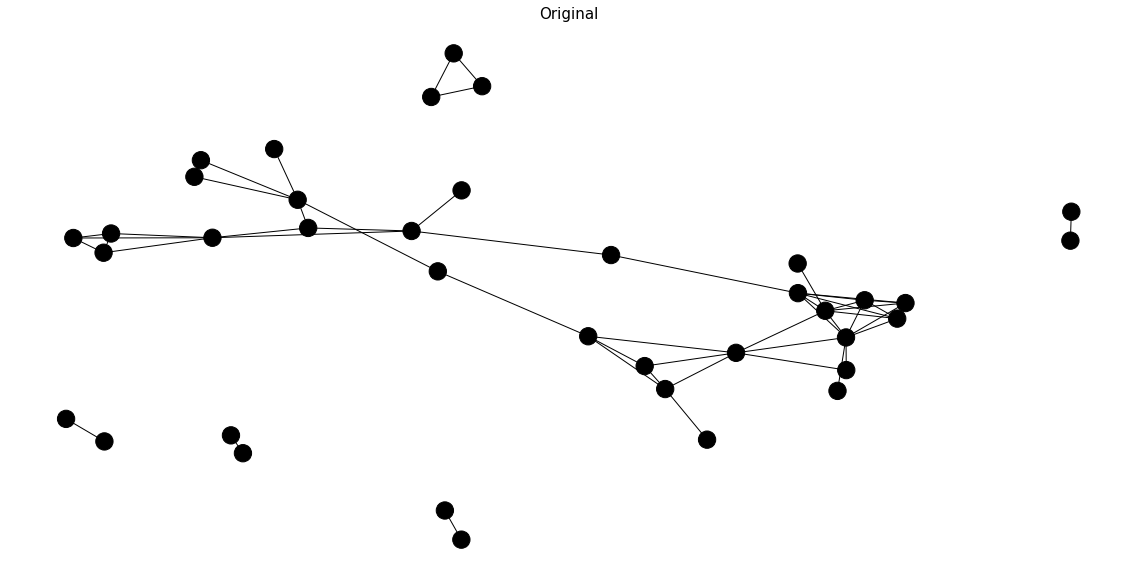

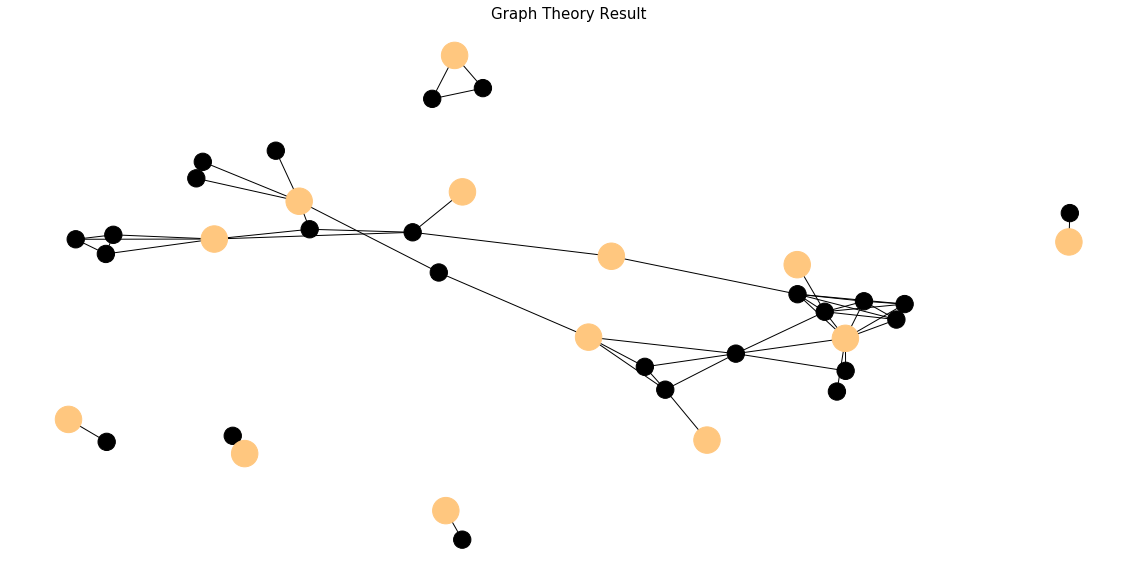

In [12]:
#slightly modify the function to return graph layout
#the layout will be used later for comparison
output,position=remove_similar(df,stopword,plot_original=True,plot_result=True)

&nbsp;
### Unsupervised Learning
&nbsp;

In [13]:
#create dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',fig_size=(10,5),
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    #preset the figure
    fig=plt.figure(figsize=fig_size)
    ax=fig.add_subplot(111)
    
    #plot left hand side
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15
    plt.legend(loc=3)
    
    #the crucial part of the function
    #both curves share x axis
    ax2=ax.twinx()
    
    #plot right hand side
    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15    
    plt.legend(loc=4)
    
    #enfin
    fig.tight_layout()
    plt.grid(grid)
    plt.title(title)
    plt.show()

In [14]:
#compute perpendicular distance
def get_distance(x,y,a,b):
    
    temp1=y-x*a-b
    temp2=(a**2+1)**0.5
    
    return np.abs(temp1/temp2)

In [15]:
#estimate parameters of linear equation
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

&nbsp;
### DBSCAN
&nbsp;

In [16]:
#treat our text mining problem as a clustering problem
#use dbscan to solve the clustering problem
#the advantage of dbscan is it can find the optimal number of clusters
#the tradeoff is we need to find the optimal epsilon
#thus, we use knn to estimate optimal epsilon for dbscan
def dbscan_algo(df,stopword):
    
    #convert text to feature vectors
    df['clean']=[' '.join(
        text2list(i,stopword,lower=True)) for i in df['title']]
    train=CountVectorizer()
    train_matrix=train.fit_transform(df['clean'])
    
    #set minimum sample of dbscan at 2
    #as we have observed in the graph theory
    #the minimum order of a connected component is 2
    #traditionally knn should take minimum sample-1
    #but 1nn doesnt work in reality, thus, we use 2nn
    clf=NearestNeighbors(n_neighbors=2)
    clf.fit(train_matrix)
    
    #prepare for visualization
    distances,_=clf.kneighbors(train_matrix)
    distances=sorted(distances.tolist(),key=lambda x:x[1])
    distances=[i[1] for i in distances]
    
    #viz and get eps
    optimal=find_optimal_eps(distances)
    
    #dbscan
    #minimum sample is determined by the worst case scenario
    #when minimum sample is at 2
    #the algorithm is equivalent to single link hierarchical clustering
    #which is commonly used in nlp problems
    clf=DBSCAN(eps=optimal,min_samples=2)
    clf.fit(train_matrix)
    
    return clf.labels_

In [17]:
#knee method for knn to find the optimal epsilon
def find_optimal_eps(distances):
    
    #compute perpendicular distance
    a,b=get_line_params(0,distances[0],len(distances)-1,distances[-1])

    distance=[]
    for i in range(len(distances)):    
        distance.append(get_distance(i,distances[i],a,b))
    
    #viz
    dual_axis_plot(np.arange(1,len(distance)+1),distances,distance,
                   x_label='Points Sampled by Distance',
                   y_label1='2-NN Distance',
                   y_label2='Perpendicular Distance',
                   legend1='2-NN',legend2='Knee',
                   title='Knee Method for KNN',
                   fst_color='#0abda0',sec_color='#720017')
    
    #get optimal eps
    optimal=distances[distance.index(max(distance))]
    
    return optimal   

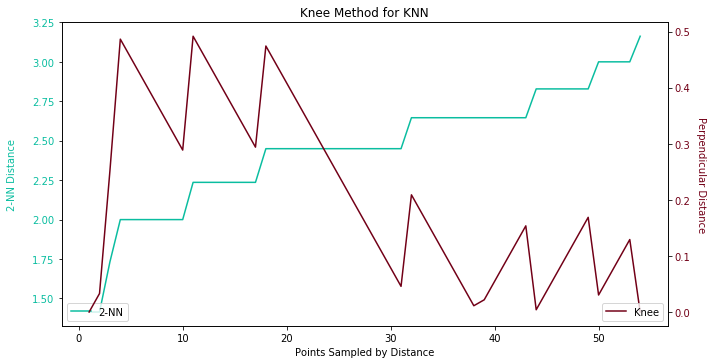

In [18]:
df['class']=dbscan_algo(df,stopword)

In [19]:
#build graph
df=add_wordlist(df,stopword)
graph=build_graph(df,stopword)

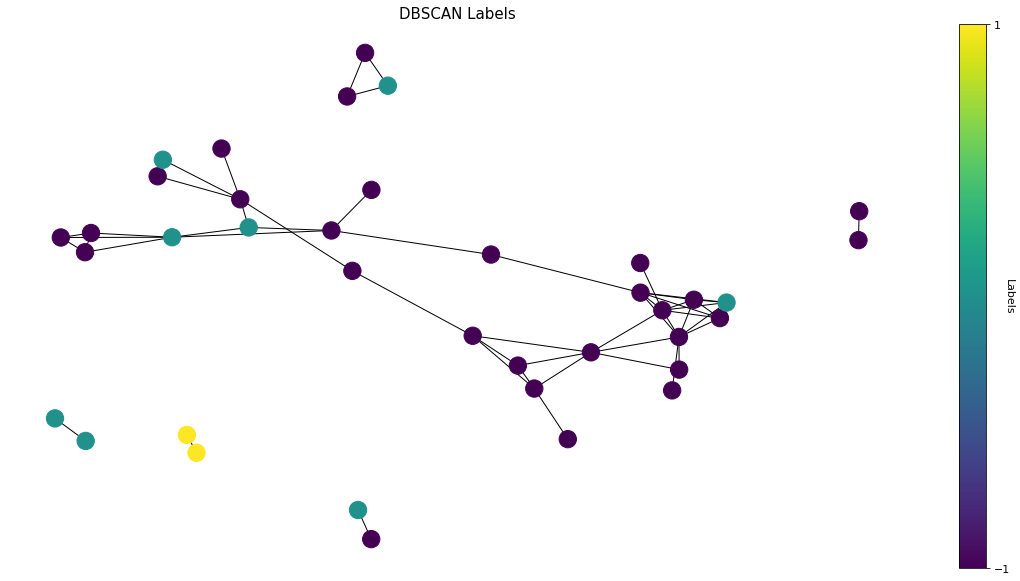

In [20]:
#visualize the classifications of dbscan
#however, there are only 3 labels
#cannot really tell what dbscan has found from nonlinear perspective
nodecolor=[df.at[i,'class'] for i in graph.nodes]

plot_graph(graph,nodecolor=nodecolor,
           position=position,nodecmap=plt.cm.viridis,
           title='DBSCAN Labels',plot_colorbar=True,
           colorbartitle='Labels')

&nbsp;
### K Means
&nbsp;

In [21]:
#as dbscan is not fit for the mission
#we use the simplest algorithm as a bench player
#although the result of kmeans is bounded by linearity
#the result of kmeans is quite intuitive and time-efficient
def kmeans_algo(df,stopword,maxk=50,**kwargs):
    
    #convert text to feature vectors
    df['clean']=[' '.join(
        text2list(i,stopword,lower=True)) for i in df['title']]
    train=CountVectorizer()
    train_matrix=train.fit_transform(df['clean'])
    
    #viz and get k
    optimal=get_optimal_k(train_matrix,maxk=maxk,**kwargs)
    
    #kmeans
    clf=KMeans(optimal)
    clf.fit(train_matrix)
    
    return clf.labels_

In [22]:
#elbow method for kmeans to find the optimal k
def get_optimal_k(train_matrix,maxk=50,plot_elbow=False):
    
    #compute inertia
    sse=[]
    for i in range(1,maxk):
        clf=KMeans(n_clusters=i)
        clf.fit(train_matrix)
        sse.append(clf.inertia_/10000)
    
    #elbow method for kmeans
    a,b=get_line_params(0,sse[0],len(sse)-1,sse[-1])

    distance=[]
    for i in range(len(sse)):    
        distance.append(get_distance(i,sse[i],a,b))
    
    #viz
    if plot_elbow:
        dual_axis_plot(np.arange(1,len(distance)+1),sse,distance,
                       x_label='Numbers of Cluster',
                       y_label1='Sum of Squared Error',
                       y_label2='Perpendicular Distance',
                       legend1='SSE',legend2='Distance',
                       title='Elbow Method for K Means',
                       fst_color='#116466',sec_color='#e85a4f')
    
    #get optimal k
    optimal=distance.index(max(distance))

    return optimal

In [23]:
#use unsupervised learning to remove similar content
def remove_similar2(df,stopword,**kwargs):
    
    #the worst case of a clustering problem is n//2 clusters
    #where n is the number of data points
    #hence, we set maxk to len(df)//2+1
    df['class']=kmeans_algo(df,stopword,maxk=len(df)//2+1,**kwargs)

    #within each label, its the same story written by different reporters
    #so we randomly select one as our final output
    result=[]
    for i in set(df['class']):
        cluster=df[df['class']==i].index.tolist()    
        result.append(rd.choice(cluster))
    
    data=df.loc[result]    
    data.reset_index(inplace=True,drop=True)
    del data['clean']
    
    return data,result

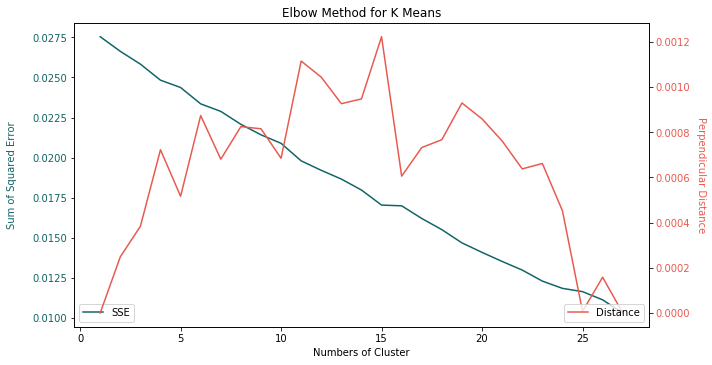

In [24]:
data,result=remove_similar2(df,stopword,plot_elbow=True)

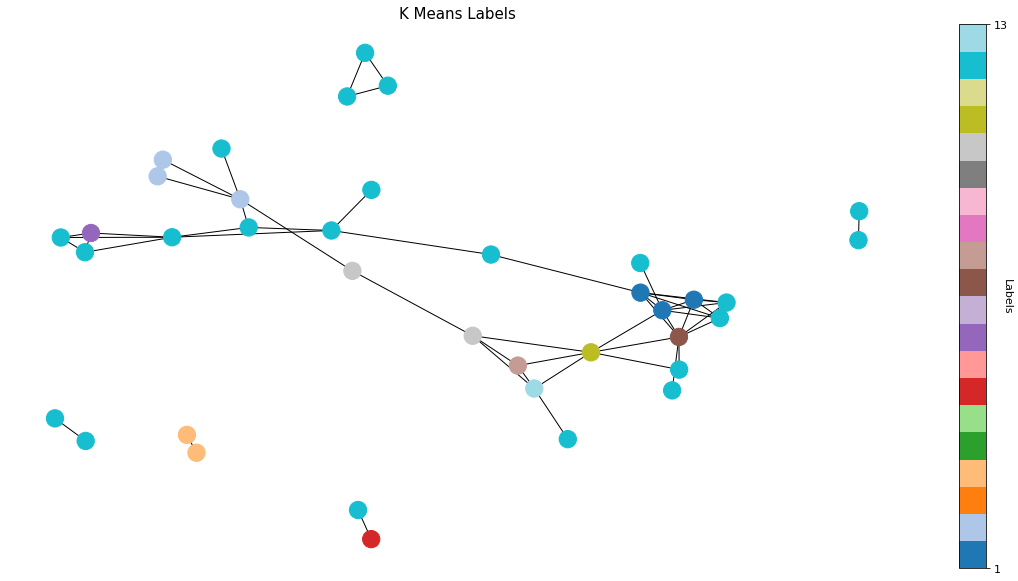

In [25]:
#visualize the classifications of kmeans
#20ish labels make more sense
nodecolor=[df.at[i,'class'] for i in graph.nodes]

plot_graph(graph,nodecolor=nodecolor,position=position,nodecmap=plt.cm.tab20,
           title='K Means Labels',plot_colorbar=True,colorbartitle='Labels')

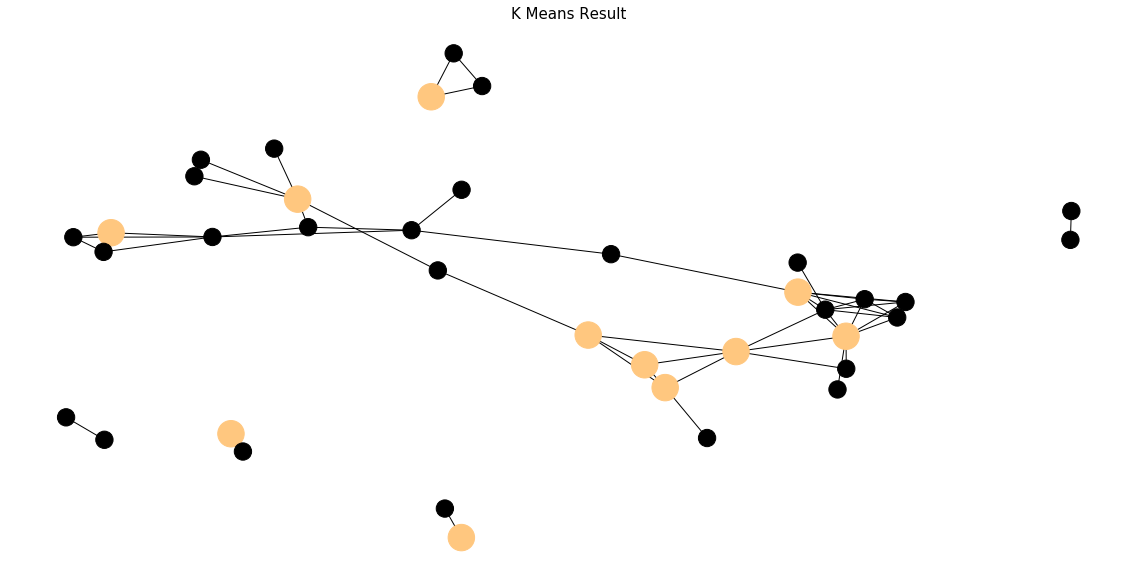

In [26]:
#visualize the result of unsupervised learning in a graph structure
#so that we can compare the result with graph theory
nodecolor=[]
for i in graph.nodes:
    if i in result:
        nodecolor.append(1)
    else:
        nodecolor.append(0)

nodesize=[]
for i in graph.nodes:
    if i in result:
        nodesize.append(700)
    else:
        nodesize.append(300)
        
plot_graph(graph,nodecolor=nodecolor,position=position,
           nodesize=nodesize,title='K Means Result')

&nbsp;
### Time Complexity
&nbsp;

In [27]:
%timeit remove_similar(df,stopword)

104 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit remove_similar2(df,stopword)

3.98 s ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
